# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn.functional as F
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rotated digits have additional *added to description).

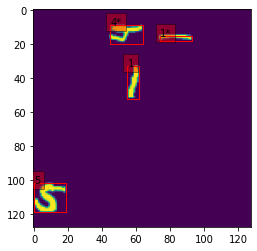

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

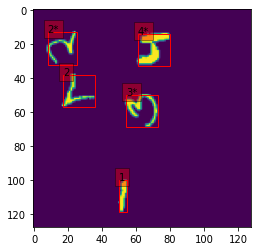

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[1].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [ ]:
import collections
import matplotlib.pyplot as plt


ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

xy_array = [] 

for canvas in TEST_CANVAS:
    for box in canvas.boxes:
        xy_array.append((box.x_diff, box.y_diff))

print(collections.Counter(xy_array))

Counter({(19, 19): 188, (19, 17): 97, (17, 19): 88, (19, 15): 80, (15, 19): 72, (13, 19): 58, (19, 13): 48, (5, 19): 36, (11, 19): 36, (19, 11): 33, (19, 5): 26, (3, 19): 24, (19, 9): 24, (16, 19): 23, (18, 19): 23, (19, 16): 23, (19, 7): 22, (19, 3): 22, (14, 19): 22, (19, 14): 21, (7, 19): 19, (9, 19): 19, (4, 19): 15, (12, 19): 14, (19, 8): 13, (19, 4): 12, (19, 6): 12, (19, 18): 12, (6, 19): 11, (19, 12): 8, (10, 19): 7, (19, 10): 7, (8, 19): 3})


In [ ]:
# We can in general see that there are some groups in the anchors.
# We have big squares sith size close to (19, 19). We also have horizontal and
# vertical rectangles with one of the dimensions being close to 19 and the other
# slightly smaller.
# Therefore I decided to choose the following anchor sizes:
# (19, 19), (19, 9), (9, 19) to adress groups mentioned above and rectangles
# of size (13, 13) to address boxes with sizes in the middle.
ANCHOR_SIZES = [(19, 19), (9, 19), (19, 9), (13, 13)]

In [ ]:
anchors = []
          
for m in range(16):
  for n in range(16):
    for size in ANCHOR_SIZES:
          x_center = 8*(m+0.5)
          y_center = 8*(n+0.5)
          half_x = (size[0]-1)/2
          half_y = (size[1]-1)/2
          anchors.append(MnistBox(x_center-half_x, y_center-half_y, 
                                       x_center+half_x, y_center+half_y, 
                                  class_nb = None))
          
ANCHORS = anchors

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [ ]:
from torch import nn


class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux

class DigitClassificationHead(torch.nn.Module):

  def __init__(self, anchors_len):
    super().__init__()
    out_size = torch.tensor(5*anchors_len/256, dtype=torch.int)
    self.layers = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, out_size, (3, 3), padding=1)
    )

  def forward(self, backbone_output):
    x_class = self.layers(backbone_output)
    x_class = x_class.permute(0, 2, 3, 1)
    x_class = x_class.reshape(-1, 5)
    return x_class


class RotationClassificationHead(torch.nn.Module):

  def __init__(self, anchors_len):
    super().__init__()
    out_size = torch.tensor(2*anchors_len/256, dtype=torch.int)
    self.layers = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, out_size, (3, 3), padding=1)
    )

  def forward(self, backbone_output):
    x_rot = self.layers(backbone_output)
    x_rot = x_rot.permute(0, 2, 3, 1)
    x_rot = x_rot.reshape(-1, 2)
    return x_rot


class BoxRegressionHead(torch.nn.Module):

  def __init__(self, anchors_len):
    super().__init__()
    out_size = torch.tensor(4*anchors_len/256, dtype=torch.int)
    self.layers = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, out_size, (3, 3), padding=1)
    )

  def forward(self, backbone_output):
    x_reg = self.layers(backbone_output)
    x_reg = x_reg.permute(0, 2, 3, 1)
    x_reg = x_reg.reshape(-1, 4)
    return x_reg


class DigitDetectionModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.anchors = ANCHORS

    self.bb = Backbone()
    self.digit_class = DigitClassificationHead(len(self.anchors))
    self.rot_class = RotationClassificationHead(len(self.anchors))
    self.box_reg = BoxRegressionHead(len(self.anchors))
    
  def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:

    bb_output = self.bb(x)
    x_class = self.digit_class(bb_output)
    x_rot = self.rot_class(bb_output)
    x_reg = self.box_reg(bb_output)

    return DigitDetectionModelOutput(self.anchors, x_class, x_rot, x_reg)

### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
from torchvision.ops import box_iou, nms

class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors

class TargetDecoder:
    def box_tensor(self, boxes_list: List[MnistBox]):
      x_mins = torch.tensor(list(map(lambda box: box.x_min, boxes_list)), device=DEVICE)
      y_mins = torch.tensor(list(map(lambda box: box.y_min, boxes_list)), device=DEVICE)
      x_maxs = torch.tensor(list(map(lambda box: box.x_max, boxes_list)), device=DEVICE)
      y_maxs = torch.tensor(list(map(lambda box: box.y_max, boxes_list)), device=DEVICE)
      return torch.stack((x_mins, y_mins, x_maxs, y_maxs), dim=1)

    def box_tensor_permute(self, boxes_list: List[MnistBox]):
      x_mins = torch.tensor(list(map(lambda box: box.x_min, boxes_list)), device=DEVICE)
      y_mins = torch.tensor(list(map(lambda box: box.y_min, boxes_list)), device=DEVICE)
      x_maxs = torch.tensor(list(map(lambda box: box.x_max, boxes_list)), device=DEVICE)
      y_maxs = torch.tensor(list(map(lambda box: box.y_max, boxes_list)), device=DEVICE)
      return torch.stack((x_mins, x_maxs, y_mins, y_maxs), dim=1)

    def rotation_tensor(self, boxes_list: List[MnistBox]):
      return torch.tensor(list(map(lambda box: box.rotated, boxes_list)), device=DEVICE)

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
      gt_boxes_tensor = self.box_tensor(canvas.boxes)
      anchors_tensor = self.box_tensor(anchors)
      ious = box_iou(anchors_tensor, gt_boxes_tensor) 

      # getting maximum of overlap in each row: we need indexes and values
      iou_values, iou_indexes = torch.max(ious, dim=1)
      match = iou_values >= iou_threshold
      not_match = iou_values < iou_threshold

      # matched_anchors
      matched_anchors = (iou_values >= iou_threshold).nonzero(as_tuple=True)[0]

      # digit and rotation classification
      rotation_classification_target = torch.zeros([len(anchors), 2], 
                                                   device=DEVICE)
      digit_classification_target = torch.zeros([len(anchors), 5], 
                                                device=DEVICE)
      for anchor_index in matched_anchors:
        class_target = canvas.boxes[iou_indexes[anchor_index]].class_nb
        class_rotation = canvas.boxes[iou_indexes[anchor_index]].rotated
        class_rotation_row = 1 if class_rotation else 0
        digit_classification_target[anchor_index, class_target-1] = 1
        rotation_classification_target[anchor_index, class_rotation_row] = 1

      # box regression
      box_regression_target = torch.zeros([len(anchors), 4], device=DEVICE)
      boxes_permute = [canvas.boxes[i] for i in iou_indexes]
      boxes_permute_tensor = self.box_tensor_permute(boxes_permute)
      anchors_permute_tensor = self.box_tensor_permute(anchors)
      box_regression_target = boxes_permute_tensor - anchors_permute_tensor
      for i in range(4):
        box_regression_target[not_match, i] = 0

      return DigitDetectionModelTarget(digit_classification_target, 
                                       rotation_classification_target,
                                       box_regression_target, 
                                       matched_anchors.tolist())

    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
    
      boxes_predict = model_output.anchors
      boxes_tensor = self.box_tensor(boxes_predict)
      regression_tensor = torch.stack([
          model_output.box_regression_output[:, 0],
          model_output.box_regression_output[:, 2],
          model_output.box_regression_output[:, 1],
          model_output.box_regression_output[:, 3]],
          dim=1
      )
      boxes_tensor = boxes_tensor + regression_tensor
      
      digit_probs = torch.sigmoid(model_output.digit_classification_output)
      high_prob_indexes = torch.unique_consecutive(
          (digit_probs > 0.6).nonzero(as_tuple=True)[0])
      
      if high_prob_indexes.shape[0] == 0:
        return []

      high_prob_boxes_tensor = boxes_tensor[high_prob_indexes, :]
      scores = torch.max(
          model_output.digit_classification_output, dim=1)[0][high_prob_indexes]

      nms_output = nms(high_prob_boxes_tensor, scores, 0.11)
  
      res = []

      for ind in nms_output:
        n = high_prob_indexes[ind]
        _, digit_class = torch.max(digit_probs[n, :], dim=0)
        digit_class = digit_class + 1
        output_rotated = model_output.rotation_classification_output[n, 1]
        output_not_rotated = model_output.rotation_classification_output[n, 0]
        res.append(MnistBox(
            model_output.anchors[n].x_min + model_output.box_regression_output[n, 0],
            model_output.anchors[n].y_min + model_output.box_regression_output[n, 2],
            model_output.anchors[n].x_max + model_output.box_regression_output[n, 1],
            model_output.anchors[n].y_max + model_output.box_regression_output[n, 3],
            digit_class,
            output_rotated > output_not_rotated
        ))
      return res

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 


class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget
    ) -> Optional[torch.Tensor]:

      if len(model_target.matched_anchors) == 0:
        return None
      
      l1_loss = torch.nn.SmoothL1Loss(reduction='mean')
      matched = model_target.matched_anchors
      # boxes predictions
      boxes_predict = model_output.box_regression_output
      boxes_target = model_target.box_regression_target
      # digit predictions
      digits_predict = model_output.digit_classification_output
      digits_target = model_target.digit_classification_target
      # rotation predictions
      rotations_predict = model_output.rotation_classification_output
      rotations_target = model_target.rotation_classification_target
      
      boxes_loss = l1_loss(boxes_predict, boxes_target)/len(matched)
      digits_loss = torchvision.ops.sigmoid_focal_loss(digits_predict, 
                                                       digits_target, reduction='mean')
      rotation_loss = torchvision.ops.sigmoid_focal_loss(rotations_predict, 
                                                         rotations_target, reduction='mean')
      
      return digits_loss + rotation_loss + boxes_loss
      
class DigitAccuracy:
    def box_tensor(self, boxes_list: List[MnistBox]):
      x_mins = torch.tensor(list(map(lambda box: box.x_min, boxes_list)))
      y_mins = torch.tensor(list(map(lambda box: box.y_min, boxes_list)))
      x_maxs = torch.tensor(list(map(lambda box: box.x_max, boxes_list)))
      y_maxs = torch.tensor(list(map(lambda box: box.y_max, boxes_list)))
      return torch.stack((x_mins, y_mins, x_maxs, y_maxs), dim=1)

    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
      if not predicted_boxes or len(predicted_boxes) == 0:
        return 0
      canvas_tensor = self.box_tensor(canvas.boxes)
      predict_tensor = self.box_tensor(predicted_boxes)
      iou_tensor = torchvision.ops.box_iou(canvas_tensor, predict_tensor)
      for i in range(len(canvas.boxes)):
        target_box = canvas.boxes[i]
        row = iou_tensor[i, :]
        if torch.count_nonzero(row > 0.1) != 1:
          return 0
        j = torch.max(row, dim=0)[1]
        predicted_box = predicted_boxes[j]
        if target_box.class_nb != predicted_box.class_nb:
          return 0
      
      return 1

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

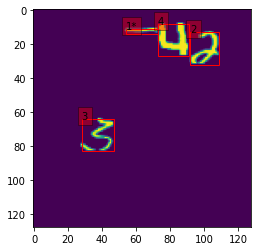

In [ ]:
TRAIN_CANVAS_SIZE = 3000
TRAIN_SEED = 10

np.random.seed(TRAIN_SEED)

TRAIN_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(TRAIN_CANVAS_SIZE)
]

TRAIN_CANVAS[0].plot()

target_decoder = TargetDecoder()
TRAIN_TARGETS = [target_decoder.get_targets(canvas, anchors) for canvas in TRAIN_CANVAS]
TEST_TARGETS = [target_decoder.get_targets(canvas, anchors) for canvas in TEST_CANVAS]

In [ ]:
from numpy.core.numeric import NaN

def train(model, dataset, optimizer):
    model.train()
    
    target_decoder = TargetDecoder()
    retina_loss = RetinaLoss()
    digit_accuracy = DigitAccuracy()
    losses = []
    acc = 0
    not_matched = 0
    nans = 0
    for i in range(len(dataset)):
        if i%100 == 0:
          print("Processing example: {0}".format(i))
        canvas = dataset[i]
        optimizer.zero_grad()
        output = model(canvas)
        target = TRAIN_TARGETS[i]
        pred = target_decoder.get_predictions(output)
        loss = retina_loss.compute_loss(output, target)
        if not loss:
          not_matched = not_matched + 1
          continue

        losses.append(loss)
        acc = acc + digit_accuracy.compute_metric(pred, canvas)
        loss.backward()
        optimizer.step()
        
    mean_loss = torch.mean(torch.tensor(losses))
    acc_percent = acc/len(dataset)*100
    return (mean_loss, acc_percent, not_matched)

In [ ]:
def test(model, dataset):
    model.eval() 

    target_decoder = TargetDecoder()
    retina_loss = RetinaLoss()
    digit_accuracy = DigitAccuracy()
    losses = []
    acc = 0
    not_matched = 0
    nans = 0
    with torch.no_grad():
      for i in range(len(dataset)):
        canvas = dataset[i]
        output = model(canvas)
        target = TEST_TARGETS[i]
        pred = target_decoder.get_predictions(output)
        loss = retina_loss.compute_loss(output, target)
        if not loss:
          not_matched = not_matched + 1
          continue
        losses.append(loss)
        acc = acc + digit_accuracy.compute_metric(pred, canvas)

    mean_loss = torch.mean(torch.tensor(losses))
    acc_percent = acc/len(dataset)*100
    return (mean_loss, acc_percent, not_matched)

In [ ]:
epochs = 10
model = DigitDetectionModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
train_dataset = TRAIN_CANVAS
test_dataset = TEST_CANVAS
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(1, epochs + 1):
  print('Training epoch: {0}\n'.format(epoch))

  mean_loss, acc, not_matched = train(model, train_dataset, optimizer)
  print('\nMean train loss: {0}'.format(mean_loss))
  print('Train percent of accuracy: {0}\n'.format(acc))
  if not_matched > 0:
    print('Train not matched: {0}\n'.format(not_matched))
  train_losses.append(mean_loss)
  train_accs.append(acc)

  mean_loss, acc, not_matched = test(model, test_dataset)
  print('Mean test loss: {0}'.format(mean_loss))
  print('Test percent of accuracy: {0}\n'.format(acc))
  if not_matched > 0:
    print('Test not matched: {0}\n'.format(not_matched))
  test_losses.append(mean_loss)
  test_accs.append(acc)


Training epoch: 1

Processing example: 0
Processing example: 100
Processing example: 200
Processing example: 300
Processing example: 400
Processing example: 500
Processing example: 600
Processing example: 700
Processing example: 800
Processing example: 900
Processing example: 1000
Processing example: 1100
Processing example: 1200
Processing example: 1300
Processing example: 1400
Processing example: 1500
Processing example: 1600
Processing example: 1700
Processing example: 1800
Processing example: 1900
Processing example: 2000
Processing example: 2100
Processing example: 2200
Processing example: 2300
Processing example: 2400
Processing example: 2500
Processing example: 2600
Processing example: 2700
Processing example: 2800
Processing example: 2900

Mean train loss: 0.008571606129407883
Train percent of accuracy: 5.433333333333333

Mean test loss: 0.004678972065448761
Test percent of accuracy: 26.5625

Training epoch: 2

Processing example: 0
Processing example: 100
Processing example: 2

Matched canvas:


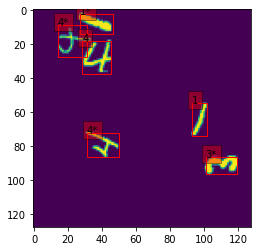

Matched canvas:


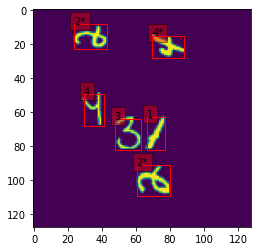

Matched canvas:


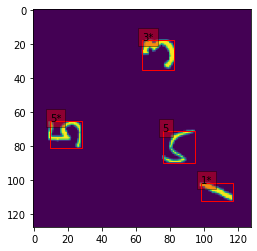

Mismatched canvas:


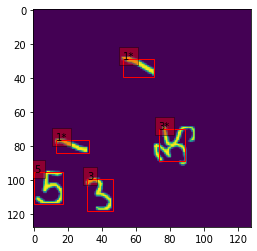

Mismatched canvas:


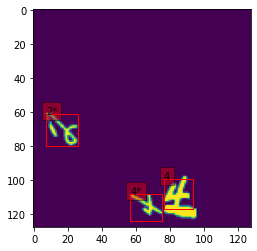

Mismatched canvas:


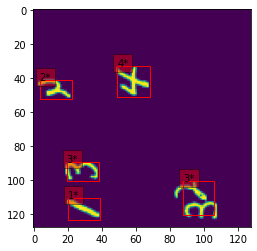

In [ ]:
# Plots of matched and mismatched examples

matched = 0
mismatched = 0

target_decoder = TargetDecoder()
digit_accuracy = DigitAccuracy()

while matched <= 3 or mismatched <= 3:
  canvas = get_random_canvas()
  output = model(canvas)
  pred = target_decoder.get_predictions(output)
  correct = digit_accuracy.compute_metric(pred, canvas)

  if correct == 1:
    matched = matched + 1
  else:
    mismatched = mismatched + 1
  
  if correct == 1 and matched <= 3:
    print("Matched canvas:")
    canva = MnistCanvas(canvas.image, pred)
    canva.plot()

  if correct == 0 and mismatched <= 3:
    print("Mismatched canvas:")
    canva = MnistCanvas(canvas.image, pred)
    canva.plot()


In [ ]:
# plot of losses
import plotly.express as px
import pandas as pd

train_losses = np.array([loss.item() for loss in train_losses])
test_losses = np.array([loss.item() for loss in test_losses])
losses = np.concatenate([train_losses, test_losses])
types = np.concatenate([np.repeat('train loss', 10), 
                        np.repeat('test loss', 10)])

plot_data = pd.DataFrame({'Loss': losses, 'Type': types})

px.line(plot_data, y='Loss', color='Type', title='Train and test losses')

In [ ]:
# plot of accuracies
import plotly.express as px
import pandas as pd

train_accs = np.array(train_accs)
test_accs = np.array(test_accs)
accs = np.concatenate([train_accs, test_accs])
types = np.concatenate([np.repeat('train accuracy', 10), 
                        np.repeat('test accuracy', 10)])

plot_data = pd.DataFrame({'Accuracy': accs, 'Type': types})

px.line(plot_data, y='Accuracy', color='Type', 
        title='Train and test accuracies')